In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    #0是均值、1是标准差、(num_examples, len(w))是样本量和样本长度。生成x为随机数
    y = torch.matmul(X, w) + b #matmul是矩阵乘法
    y += torch.normal(0, 0.01, y.shape) #再添加一个随机噪音
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.2453, 2.1232]) 
label: tensor([-0.5365])


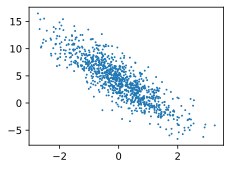

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [5]:
def data_iter(batch_size, features, labels):  #读取数据集
    #批量大小，特征，标号
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)  #打乱下标
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices] #返回迭代器


In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.0234, -2.0027],
        [-0.1117,  0.4757],
        [-0.8026, -1.2683],
        [-0.7398,  0.8608],
        [ 0.7333,  0.6451],
        [ 0.1784, -0.5195],
        [-0.3258, -1.6510],
        [-0.9317, -0.0767],
        [-0.1778, -2.2907],
        [ 0.8392,  1.0224]]) 
 tensor([[ 6.9552],
        [ 2.3658],
        [ 6.9039],
        [-0.2067],
        [ 3.4721],
        [ 6.3234],
        [ 9.1611],
        [ 2.5942],
        [11.6231],
        [ 2.4061]])


In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [10]:
def sgd(params, lr, batch_size):  #@save
    """
    小批量随机梯度下降
    params：list列表
    lr：学习率
    batch_size：大小
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
lr = 0.03
num_epochs = 3 #整个数据集做3次扫描
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y线性回归模型的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036009
epoch 2, loss 0.000128
epoch 3, loss 0.000051


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
